In [32]:
import iris
import iris.coord_categorisation as coord_cat
import sys
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
import scipy
from scipy import stats
from collections import Counter
from scipy.fftpack import fft, fftfreq
import sys
import matplotlib.animation as animation
import csv
import pandas as pd
from datetime import datetime
import math

In [36]:
import re
import inspect


def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))
    
print(rescue_code(run_sim))

None


In [ ]:
def run_sim(N, beta0, gamma, N_days, s0, tests, false_symp, beta_step, N_lockdown, mode, pia_series):
    #initial vals for populations
    R = np.zeros([1])
    symp0 = s0
    symp = np.array([symp0])
    
    #generate initial pi
    pia = pia_series[0]
    I = np.array([symp[0]*N/(1-pia)])
    S = np.array([N - I[0]])
    symp_new_cases = np.array([symp0])
    #loop over number of timesteps, incrementing S,R,I and symp.
    k = np.log(2)/3

    for i in range(1, N_days):
        if i < N_lockdown + 14:
            beta = beta0
        else:
            if mode == 'step':
                beta = beta0 - beta_step
            if mode == 'decay':
                k = np.log(2)/3
                beta = beta0 - beta_step * (1 - np.exp(-(i - (N_lockdown + 14))*k))
        
        #if i > 88:
        #    beta = beta0 - 0.5*beta_step
        
        if split_betas == True:
            beta = beta*((1-pia) + 0.75*pia)
        
        deltaS, deltaR, deltaI = Timestep(N, beta, gamma, S[-1], R[-1], I[-1])
        S = np.append(S, S[-1] + deltaS)
        R = np.append(R, R[-1] + deltaR)
        I = np.append(I, I[-1] + deltaI)
        
        #define pia for this timestep based on ratio of new symptomatics and 
        pia = pia_series[i]
        
        #get symptomatic number for this timestep
        symp = np.append(symp, (1-pia)*I[-1]/N)
        
        #calculate number of new symptomatic cases for this timestep
        new_cases = I[-1]/N - I[-2]/N + deltaR/N
        symp_new_cases = np.append(symp_new_cases, (1 - pia)*new_cases)

    return S,R,I,symp,symp_new_cases


[-4.110873864173311, -4.468719083260234, -4.731712929076937, -4.9397455810104365, -5.111864840056149, -5.258663906712191, -5.386645902913156, -5.500091349268806, -5.583496308781699, -5.660477240717339, -4.345658990503007, -5.798659660299182, -5.861193141070666, -5.920045264878189, -5.975625483078236, -5.934570204040535, -5.891756957752944, -5.847028432483855, -5.80020520788513, -5.7510814076354215, -5.699419228028471, -5.644941974633268, -6.088998597361825, -5.009137574434436, -6.629659761384686, -6.8193031614701445, -6.978651100615174, -6.017450499181229, -6.54370627459069, -5.631372693459281, -4.679802801833349, -5.8623838767083445, -4.854693689731269, -3.730123928404655, -3.85916744586879, -3.3930291920103115, -3.70654405945303, -3.432069337744673, -3.910099387753943, -3.9563177698041367, -3.600812465062084, -3.222597189283461, -3.449813101871267, -2.2095130627410424, -2.8186979586336265, -3.380331353495056, -2.45205581790013, -1.992394695328228, -2.093030463147266, -2.0541859924429

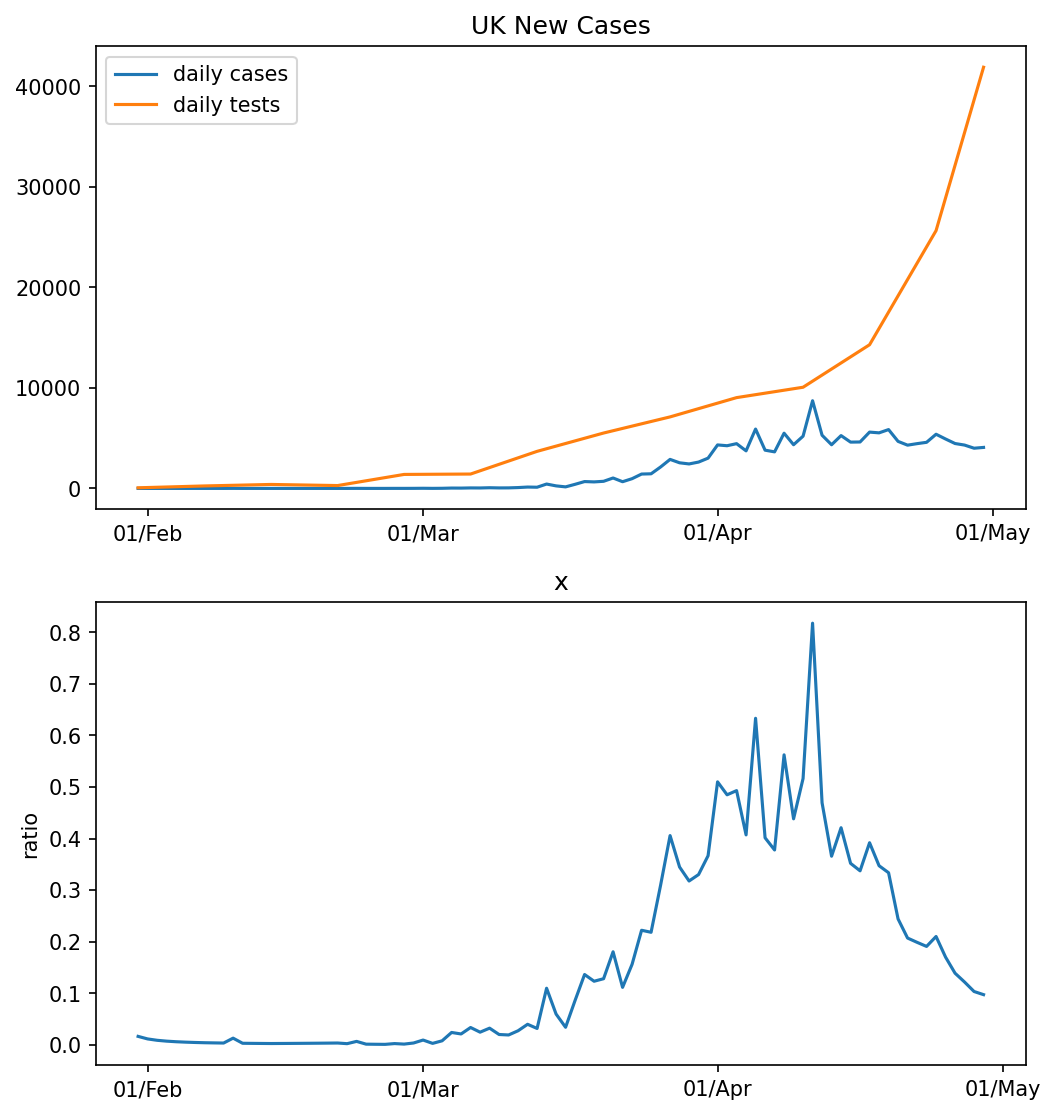

In [34]:
## load GB case data. 
df = pd.read_csv('total-cases-covid-19.csv')

#isolate country that we want, work out when the 1st case was.
GB = df.loc[df['Code'] == 'GBR'].values[:]
cumulative = GB[:,3]

#find index through the year of 1st date
date0 = GB[0,2]
datetime_object = datetime.strptime(date0, '%b %d, %Y')
first_index = int(datetime_object.timetuple().tm_yday)

#rate of cases and new daily cases
GB_new_cases = cumulative[1:] - cumulative[0:-1]

#load test data
df = pd.read_csv('Testing_data_UK.csv')
weekly_tests = df.values[:,1]/7
weeks = np.arange(0,len(GB_new_cases)+7,7)
days = np.arange(len(GB_new_cases))

#interpolate weekly to daily
f = scipy.interpolate.interp1d(weeks, weekly_tests[0:len(weeks)])
daily_tests = f(days)

#calculate xt
GB_new_cases_nozero = GB_new_cases.copy()
GB_new_cases_nozero[GB_new_cases_nozero == 0] = 1.
xt = np.array(GB_new_cases_nozero)/np.array(daily_tests)
logxt = [np.log(xt[i]) for i in range(len(xt))]
print(logxt)


fig = plt.figure(figsize=(8, 9), dpi = 150)
gs1 = gridspec.GridSpec(2, 1)

plt1 = plt.subplot(gs1[0,0])
plt.plot(np.arange(len(GB_new_cases)), GB_new_cases, label = 'daily cases')
plt.plot(np.arange(len(GB_new_cases)), daily_tests, label = 'daily tests')
plt.title('UK New Cases')
plt.xticks([1,30,61,90],['01/Feb', '01/Mar', '01/Apr', '01/May'])
#plt.yticks(np.arange(1000,70000,5000),np.arange(1000,70000,5000))
#plt.ylim(0,70000)
plt.legend()

plt1 = plt.subplot(gs1[1,0])
plt.plot(np.arange(len(GB_new_cases)), xt)
plt.ylabel('ratio')
plt.title('x')
plt.xticks([1,30,61,91],['01/Feb', '01/Mar', '01/Apr', '01/May'])
plt.show()

In [78]:
##functions
## function to perform 1 timestep of the SRI model given beta, gamma, N
## and values of populations from previous timestep, returns changes in each probability of population (S, R, I)
def Timestep(N, beta, gamma, S_m, R_m, I_m):
    deltaS = -1 * beta * I_m * S_m/N
    deltaR = gamma * I_m
    deltaI = beta * I_m * S_m/N - gamma * I_m
    
    return deltaS, deltaR, deltaI

def generate_pi(xt, b1, b2):   
    logxt = np.array([np.log(xt[i]/(1-xt[i])) for i in range(len(xt))])
    Lambda = np.exp(b1 + b2*logxt)
    pia = Lambda/(1+Lambda)
    return pia

#modified version of the run_sim function used to a step_function beta
def run_sim(N, beta0, gamma, N_days, s0, false_symp, beta_step, N_lockdown, mode, pia_series):
    #initial vals for populations
    R = np.zeros([1])
    symp0 = s0
    symp = np.array([symp0])
    
    #generate initial pi
    pia = pia_series[0]
    I = np.array([symp[0]*N/(1-pia)])
    S = np.array([N - I[0]])
    symp_new_cases = np.array([symp0])
    #loop over number of timesteps, incrementing S,R,I and symp.
    k = np.log(2)/3

    for i in range(1, N_days):
        if i < N_lockdown + 14:
            beta = beta0
        else:
            if mode == 'step':
                beta = beta0 - beta_step
            if mode == 'decay':
                k = np.log(2)/3
                beta = beta0 - beta_step * (1 - np.exp(-(i - (N_lockdown + 14))*k))
        
        #if i > 88:
        #    beta = beta0 - 0.5*beta_step
        
        if split_betas == True:
            beta = beta*((1-pia) + 0.75*pia)
        
        deltaS, deltaR, deltaI = Timestep(N, beta, gamma, S[-1], R[-1], I[-1])
        S = np.append(S, S[-1] + deltaS)
        R = np.append(R, R[-1] + deltaR)
        I = np.append(I, I[-1] + deltaI)
        
        #define pia for this timestep based on ratio of new symptomatics and 
        pia = pia_series[i]
        
        #get symptomatic number for this timestep
        symp = np.append(symp, (1-pia)*I[-1]/N)
        
        #calculate number of new symptomatic cases for this timestep
        new_cases = I[-1]/N - I[-2]/N + deltaR/N
        symp_new_cases = np.append(symp_new_cases, (1 - pia)*new_cases)

    return S,R,I,symp,symp_new_cases


### exploring the variability of the total symptomatic curve with pia
def pia_and_beta_vs_symp(b2, b1_max, beta_step, b1_step, beta_drop_max, real_symp_new_cases, mode):
    b1s = np.arange(0,b1_max,b1_step)
    beta_drops = np.arange(0,beta_drop_max, beta_step)
    RMS = np.zeros([len(b1s),len(beta_drops)])

    for i in range(len(b1s)):
        for j in range(len(beta_drops)):
            pia_series = generate_pi(xt, b1s[i], b2)
            #print(b1s[i], beta_drops[j])
            S,R,I,symp,symp_new_cases = run_sim(N, beta0, gamma, N_days, s0, false_symp, beta_drops[j], N_lockdown, 'decay', pia_series)

            RMS[i,j] = np.sqrt(np.mean((real_symp_new_cases - symp_new_cases)**2))
    return b1s, beta_drops, RMS


#### function to perform a bootstrap stats test on two sets of squared residuals data
#### this is done by pooling both residual datasets, randomly selecting
#### 2 random subsets of the same size as original data
def bootstrap_sig_test(symp_new_cases_b20, symp_new_cases_b2_other):
   
    #compute square of residuals for both simulations
    sq_residual_b20 = (symp_new_cases_b20 - GB_new_cases/N)**2
    sq_residual_b2_other = (symp_new_cases_b2_other - GB_new_cases/N)**2
    
    ### real difference in SSW rates
    real_dif = np.mean(sq_residual_b2_other**0.5) - np.mean(sq_residual_b20**0.5)

    ### pool residual squared datasets
    residual_pooled = np.append(sq_residual_b20**0.5, sq_residual_b2_other**0.5)

    ## loop over bootstrapping, partition into 2 subsets (same size as original SSW arrays)
    ## store difference in SSW rates in dif array
    dif = np.empty(0)
    for j in range(10000):

        ind = np.random.choice(range(residual_pooled.shape[0]), size=N_days, replace=False)
        rest = np.array([i for i in range(0,residual_pooled.shape[0]) if i not in ind])
        
        dummy1 = residual_pooled[ind]
        dummy2 = residual_pooled[rest]
        
        dif = np.append(dif, np.mean(dummy1) - np.mean(dummy2))

    percentiles = np.percentile(dif, np.arange(0,100.001,0.001))
    
    idx = (np.abs(percentiles - real_dif)).argmin()
    
    return dif, real_dif, idx






In [45]:
#parameters converted to day units of time
gamma = 1 - 0.5**(1/8.)

N_days = len(GB_new_cases)
N = 67810208.
s0 = 2./N
false_symp = 0
b1_max = 7
N_lockdown = 52
split_betas = False
R0 =  2.95
beta0 = gamma*R0
b2 = 0

#run the optimisation for b2 = 0 and retain values for bootstrapping
b1s_b20, beta_drops_b20, RMS_b20 = pia_and_beta_vs_symp(b2, b1_max, 0.01, 0.1, beta0, GB_new_cases/N, 'decay')
min_b1_b20 = b1s_b20[np.where(RMS_b20 == np.min(RMS_b20))[0]]
min_beta_b20 = beta0 - beta_drops_b20[np.where(RMS_b20 == np.min(RMS_b20))[1]]


In [75]:
print(min_b1_b20)

[5.5]


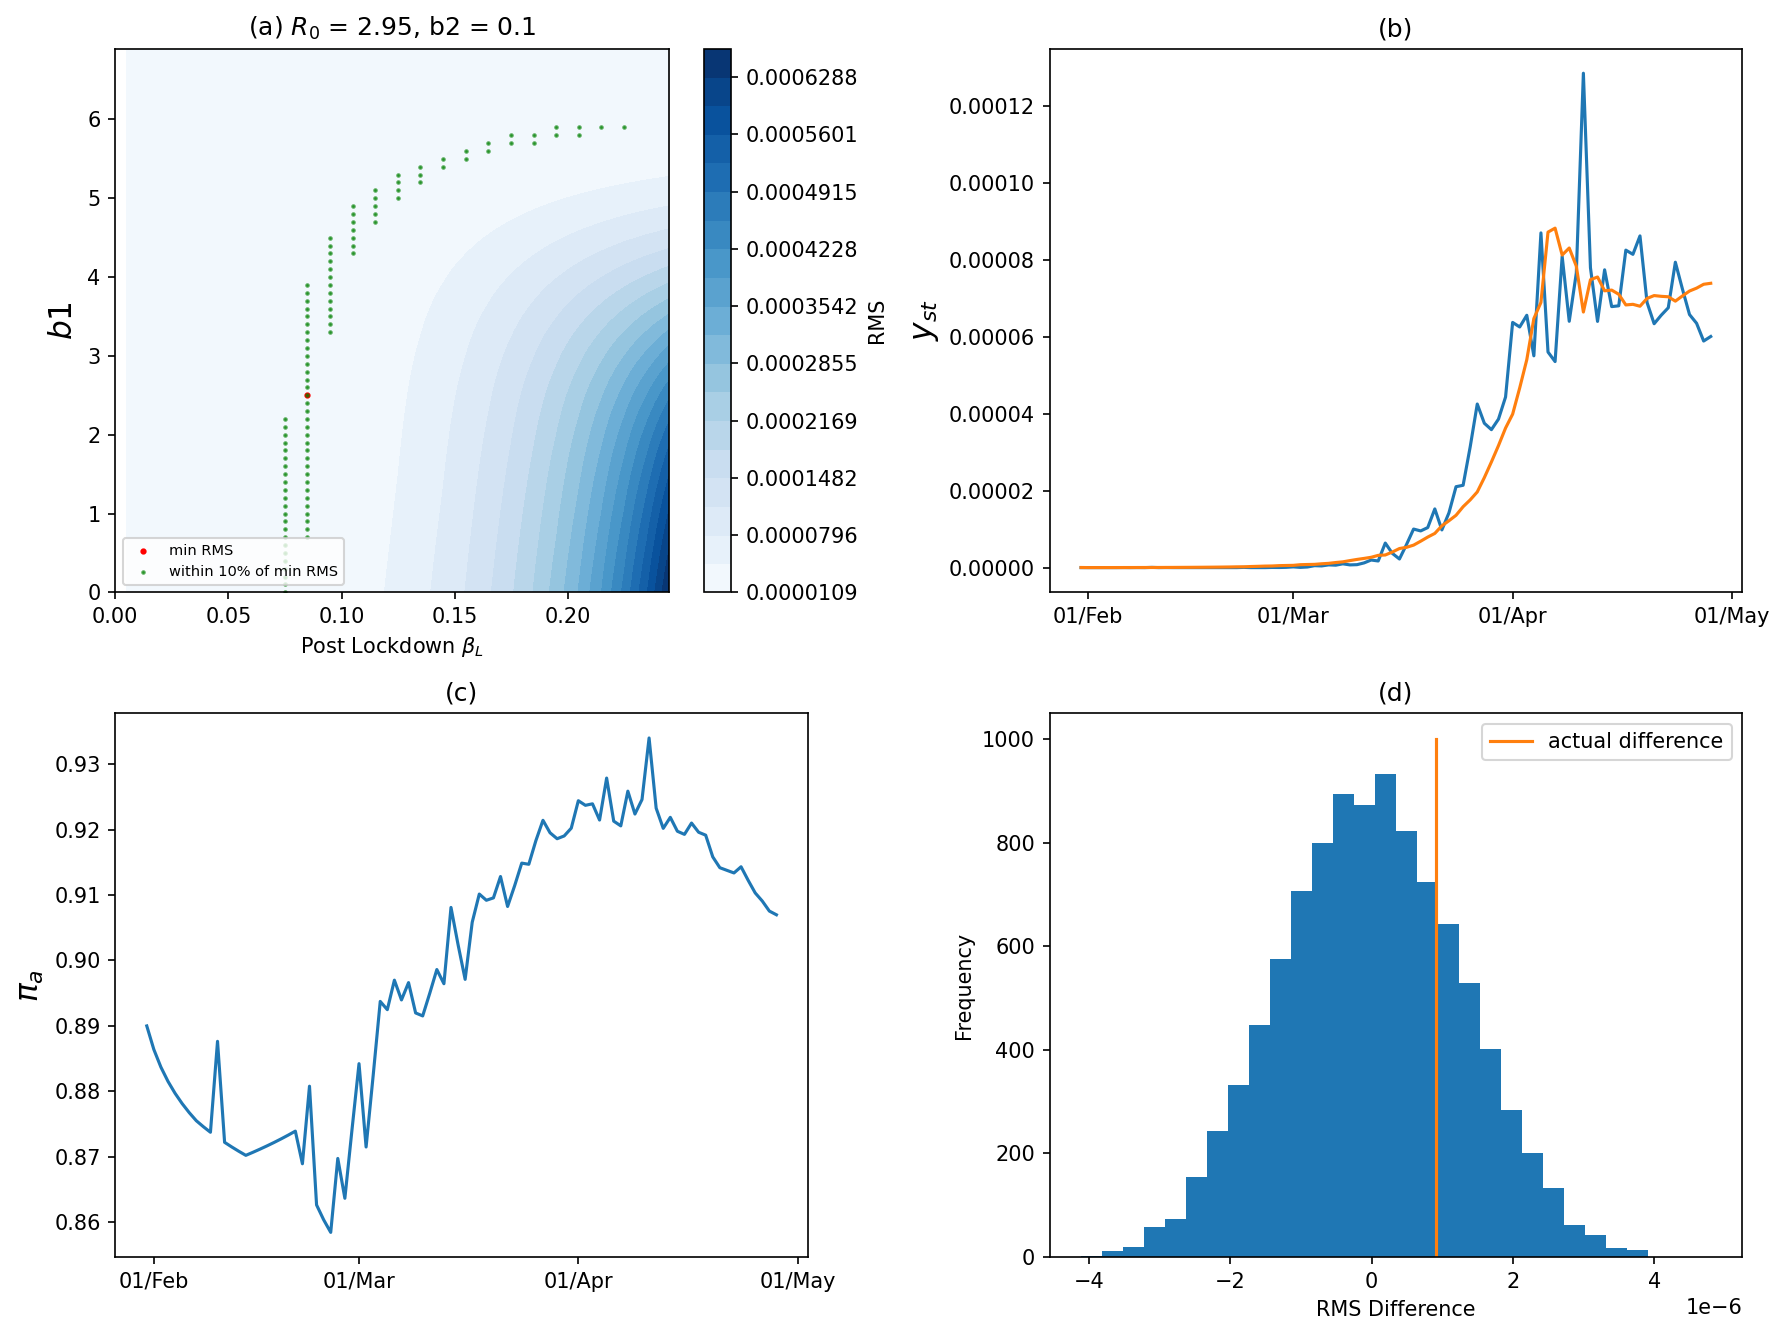

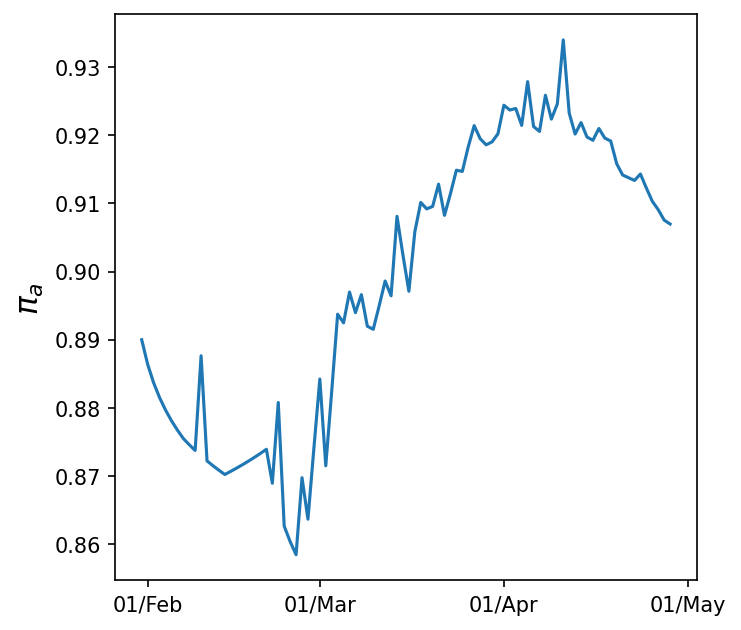

In [161]:
def run_and_plot(b2):
    b1s, beta_drops, RMS = pia_and_beta_vs_symp(b2, b1_max, 0.01, 0.1, beta0, GB_new_cases/N, 'decay')
    
    fig = plt.figure(figsize=(12, 9), dpi = 150)
    gs1 = gridspec.GridSpec(2, 2)
    plt1 = plt.subplot(gs1[0,0])
    cs = plt.contourf(beta0 - beta_drops, b1s, RMS, levels = np.linspace(np.min(RMS),np.max(RMS),20), cmap = 'Blues')
    min_b1 = b1s[np.where(RMS == np.min(RMS))[0]]
    min_beta = beta0 - beta_drops[np.where(RMS == np.min(RMS))[1]]
    bottom5_b1 = b1s[np.where(RMS < 1.1*np.min(RMS))[0]]
    bottom5_beta = beta0 - beta_drops[np.where(RMS < 1.1*np.min(RMS))[1]]
    plt.scatter(min_beta, min_b1, color = 'red', s = 4, label = 'min RMS')
    plt.scatter(bottom5_beta, bottom5_b1, color = 'g', alpha = 0.6, s = 1.5, label = 'within 10% of min RMS')
    #plt.ylim(0,1.02)
    plt.xlim(0,beta0)
    plt.xlabel('Post Lockdown $\\beta_L$')
    plt.title('(a) $R_0$ = 2.95, b2 = ' + str(b2))
    plt.ylabel('$b1$', fontsize = 15)
    plt.colorbar(cs, label = 'RMS')
    plt.legend(loc = 3, fontsize = 7)

    plt1 = plt.subplot(gs1[0,1])
    pia_series = generate_pi(xt, min_b1[0], b2)
    S,R,I,symp,symp_new_cases = run_sim(N, beta0, gamma, N_days, s0, false_symp, beta0 - min_beta, N_lockdown, 'decay', pia_series)
    plt.plot(np.arange(len(GB_new_cases)), GB_new_cases/N)
    plt.plot(np.arange(len(symp_new_cases)), symp_new_cases)
    #plt.plot(np.arange(len(symp_new_cases)), symp)
    plt.ylabel('$y_{st}$', fontsize = 15)
    plt.xticks([1,30,61,92],['01/Feb', '01/Mar', '01/Apr', '01/May'])
    plt.title('(b)')
    plt.tight_layout()
    
    plt1 = plt.subplot(gs1[1,0])
    plt.plot(np.arange(len(GB_new_cases)), pia_series)
    plt.ylabel('$\pi_a$', fontsize = 15)
    plt.title('(c)')
    plt.xticks([1,30,61,92],['01/Feb', '01/Mar', '01/Apr', '01/May'])
        
    #run simulation with b2 = 0 and other parameter combinations
    pia_series_b20 = generate_pi(xt, min_b1_b20[0], 0)
    symp_new_cases_b20 = run_sim(N, beta0, gamma, N_days, s0, false_symp, beta0 - min_beta_b20, N_lockdown, 'decay', pia_series_b20)[4]
    
    #bootstrapping method for confidence interval between b2 = 0 and b2 = current b2
    if b2!= 0:
        dif, real_dif, percentile_index = bootstrap_sig_test(symp_new_cases_b20, symp_new_cases)
    
        plt1 = plt.subplot(gs1[1,1])
        plt.hist(dif, bins=30)  # `density=False` would make counts
        plt.ylabel('Frequency')
        plt.plot([real_dif,real_dif], [0,1000], label = 'actual difference')
        plt.xlabel('RMS Difference')
        plt.title('(d)')
        plt.legend(loc = 1)
    plt.tight_layout()    
    plt.show()
    fig.savefig('./covid_optimisations/variable_pi_plot_b2=' + str(b2) + '.png', dpi = 200)

    fig = plt.figure(figsize=(5, 5), dpi = 150)
    #plt1 = plt.subplot(gs1[0,1])
    pia_series = generate_pi(xt, min_b1[0], b2)
    S,R,I,symp,symp_new_cases = run_sim(N, beta0, gamma, N_days, s0, false_symp, beta0 - min_beta, N_lockdown, 'decay', pia_series)
    plt.plot(np.arange(len(GB_new_cases)), pia_series)
    plt.ylabel('$\pi_a$', fontsize = 15)
    #plt.title()
    plt.xticks([1,30,61,92],['01/Feb', '01/Mar', '01/Apr', '01/May'])
    plt.show()
    fig.savefig('./covid_optimisations/pi_at_b2_=_0.1.pdf', dpi = 500)
    

    
    
    

#for i in([0, 0.05, 0.1,1,1.6,2,3]):

run_and_plot(0.1)

    
    

In [61]:
0.0000088-0.0000094

-5.999999999999993e-07

No handles with labels found to put in legend.


[5.5]


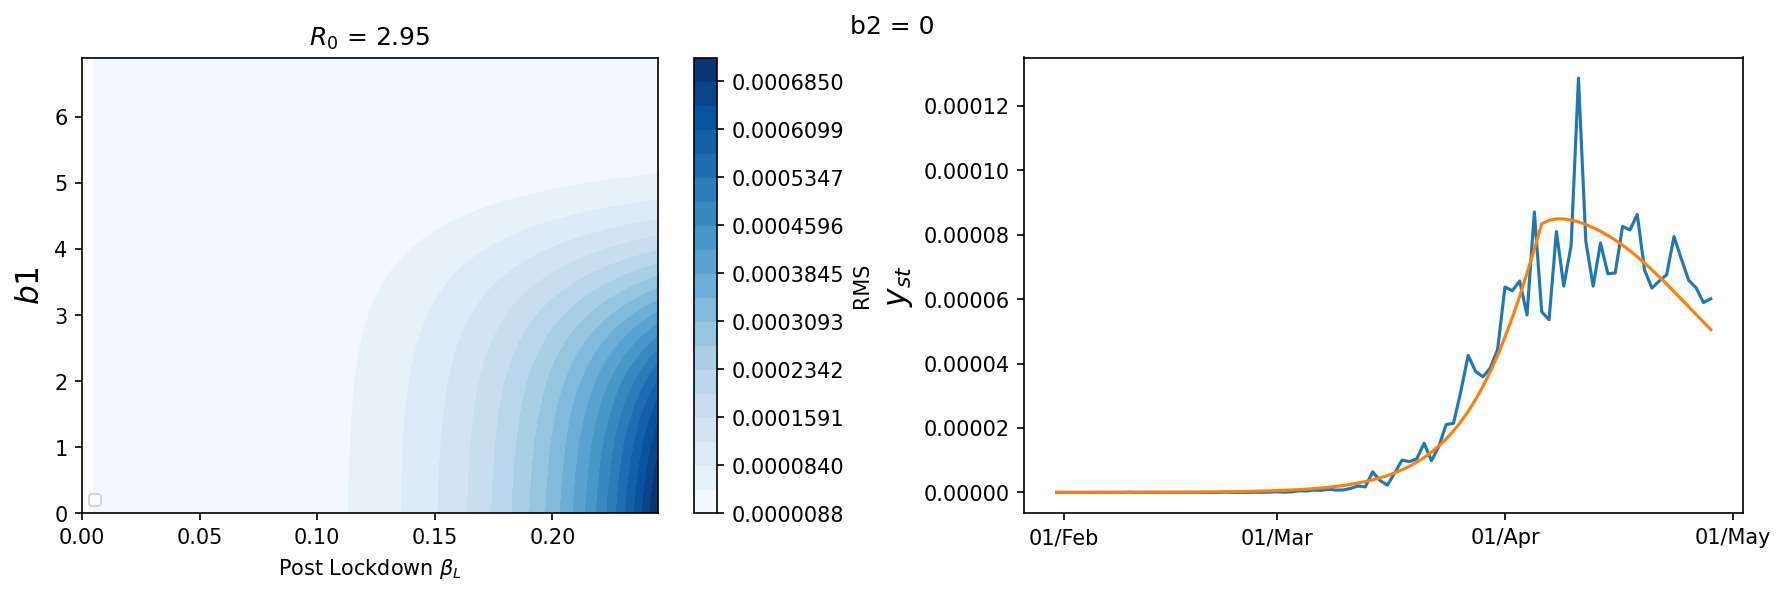

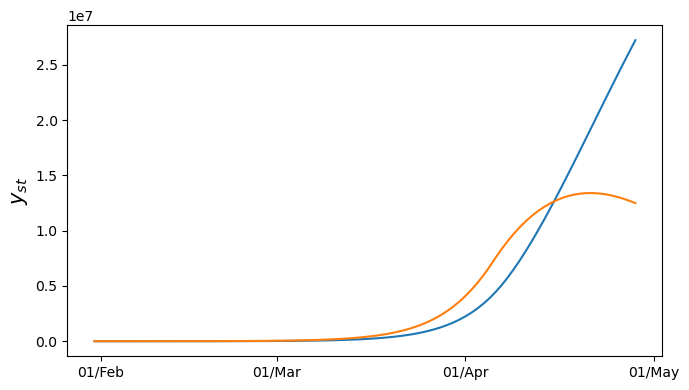

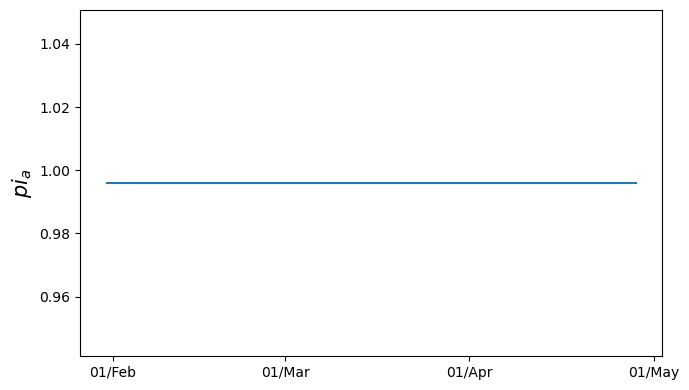

In [283]:
fig = plt.figure(figsize=(12, 4), dpi = 150)

plt.suptitle('b2 = 0')
gs1 = gridspec.GridSpec(1, 2)
plt1 = plt.subplot(gs1[0,0])
cs = plt.contourf(beta0 - beta_drops, b1s, RMS, levels = np.linspace(np.min(RMS),np.max(RMS),20), cmap = 'Blues')
min_b1 = b1s[np.where(RMS == np.min(RMS))[0]]
min_beta = beta0 - beta_drops[np.where(RMS == np.min(RMS))[1]]
bottom5_pia = b1s[np.where(RMS < 1.1*np.min(RMS))[0]]
bottom5_b1 = beta0 - beta_drops[np.where(RMS < 1.1*np.min(RMS))[1]]
#plt.scatter(min_beta, min_b1, color = 'red', s = 4, label = 'min RMS')
#plt.scatter(bottom5_beta, bottom5_b1, color = 'g', alpha = 0.6, s = 1.5, label = 'within 10% of min RMS')
#plt.ylim(0,1.02)
plt.xlim(0,beta0)
plt.xlabel('Post Lockdown $\\beta_L$')
plt.title('$R_0$ = 2.95')
plt.ylabel('$b1$', fontsize = 15)
plt.colorbar(cs, label = 'RMS')
plt.legend(loc = 3, fontsize = 7)
plt.tight_layout()
#fig.savefig('./covid_optimisations/gamma_=_0.109_RMS_R0_=_' + str(R0) +'latest_data.png', dpi = 200)

print(min_b1)

plt1 = plt.subplot(gs1[0,1])
pia_series = generate_single_pi(xt, min_b1[0], b2)
S,R,I,symp,symp_new_cases = run_sim(N, beta0, gamma, N_days, s0, tests, false_symp, beta0 - min_beta, N_lockdown, 'decay', pia_series)
plt.plot(np.arange(len(GB_new_cases)), GB_new_cases/N)
plt.plot(np.arange(len(symp_new_cases)), symp_new_cases)
plt.ylabel('$y_{st}$', fontsize = 15)
plt.xticks([1,30,61,92],['01/Feb', '01/Mar', '01/Apr', '01/May'])
plt.tight_layout()
plt.show()




fig = plt.figure(figsize = (7,4), dpi = 100)
#plt.plot(np.arange(len(symp_new_cases)), S)
plt.plot(np.arange(len(symp_new_cases)), R)
plt.plot(np.arange(len(symp_new_cases)), I)
plt.ylabel('$y_{st}$', fontsize = 15)
plt.xticks([1,30,61,92],['01/Feb', '01/Mar', '01/Apr', '01/May'])
plt.tight_layout()
plt.show()

fig = plt.figure(figsize = (7,4), dpi = 100)
plt.plot(np.arange(len(GB_new_cases)), pia_series)
plt.ylabel('$pi_a$', fontsize = 15)
plt.xticks([1,30,61,92],['01/Feb', '01/Mar', '01/Apr', '01/May'])
plt.tight_layout()
plt.show()

In [147]:
import matplotlib.image as mpimg

img1 = mpimg.imread('./covid_optimisations/figures_for_paper/FRAgamma_=_0.083_best_fit_R0_=_2.95latest_data.png')
img2 = mpimg.imread('./covid_optimisations/figures_for_paper/ITAgamma_=_0.083_best_fit_R0_=_3.9latest_data.png')
img4 = mpimg.imread('./covid_optimisations/countries/ESPgamma_=_0.083_best_fit_R0_=_3.9latest_data.png')
img5 = mpimg.imread('./covid_optimisations/figures_for_paper/USAgamma_=_0.083_best_fit_R0_=_3.3latest_data.png')
img6 = mpimg.imread('./covid_optimisations/countries/SWEgamma_=_0.083_best_fit_R0_=_2.5latest_data.png')






In [159]:
fig = plt.figure(figsize=(20, 20), dpi = 500)
gs1 = gridspec.GridSpec(3, 2)
grid = np.arange(6).reshape([3,2])
gs1.update(wspace=0.01, hspace = 0.01)

ims = [[img1,img2],[img4, img5],[img6]]
titles = [['France','Italy'],['Spain', 'USA'],['Sweden']]

for i in range(3):
        for j in range(2):
            print(i,j)
            if grid[i,j] < 5:
                ax = plt.subplot(gs1[i,j])
                ax.set_title('         ' + titles[i][j], fontsize = 20)
                plt.axis('off')
                plt.imshow(ims[i][j])
plt.tight_layout()
plt.show()
fig.savefig('./covid_optimisations/countries_combined.pdf', dpi = 600)


0 0
0 1
1 0
1 1
2 0
2 1


<ipython-input-159-8e50fdc0985a>:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
